## Решающие деревья, случайные леса и градиентный бустинг

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, make_scorer, average_precision_score
from sklearn.pipeline import Pipeline
import seaborn as sns
import zipfile
import os
import glob
import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

# 1. Решающие деревья. Визуализация.

In [23]:
from sklearn.datasets import make_moons, make_circles, make_classification

datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2,
                    class_sep=.8, random_state=3, n_redundant=0)
]
dataset_names = ['circles', 'moons', '3-class']

In [24]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

### 1.1 (1 балл) Дерево с параметрами по умолчанию

circles: train acc=1.0000, test acc=0.7333, depth=6, leaves=14
moons: train acc=1.0000, test acc=0.8667, depth=4, leaves=8
3-class: train acc=1.0000, test acc=0.8333, depth=7, leaves=13


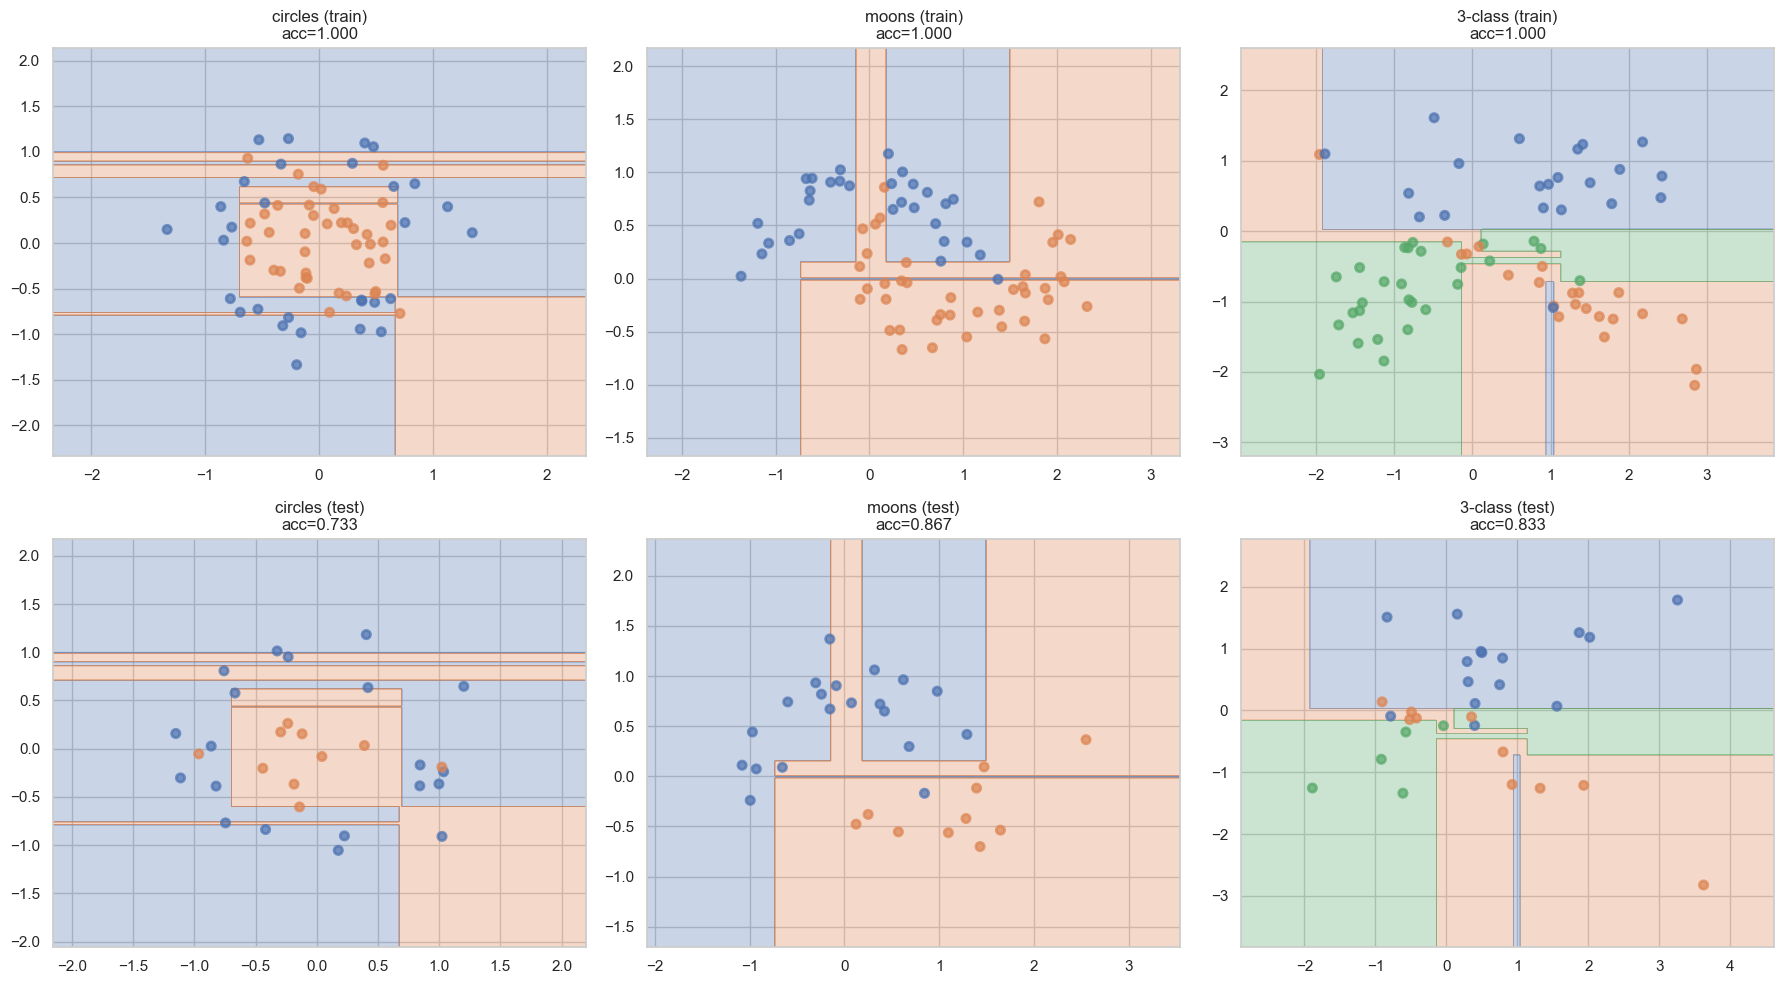

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    acc_train = accuracy_score(y_train, clf.predict(X_train))
    acc_test = accuracy_score(y_test, clf.predict(X_test))
    
    # Разделяющая поверхность на train
    plt.sca(axes[0, i])
    plot_surface(clf, X_train, y_train)
    axes[0, i].set_title(f'{dataset_names[i]} (train)\nacc={acc_train:.3f}')
    
    plt.sca(axes[1, i])
    plot_surface(clf, X_test, y_test)
    axes[1, i].set_title(f'{dataset_names[i]} (test)\nacc={acc_test:.3f}')
    
    print(f'{dataset_names[i]}: train acc={acc_train:.4f}, test acc={acc_test:.4f}, '
          f'depth={clf.get_depth()}, leaves={clf.get_n_leaves()}')

plt.tight_layout()
plt.show()

**Ответ:** Деревья с параметрами по умолчанию дают accuracy=1.0 на обучающей выборке (полное переобучение), а на тестовой — значительно ниже. Разделяющая поверхность имеет сложную "зубчатую" форму, что говорит о переобучении.

### 1.2 (1.5 балла) Подбор гиперпараметров

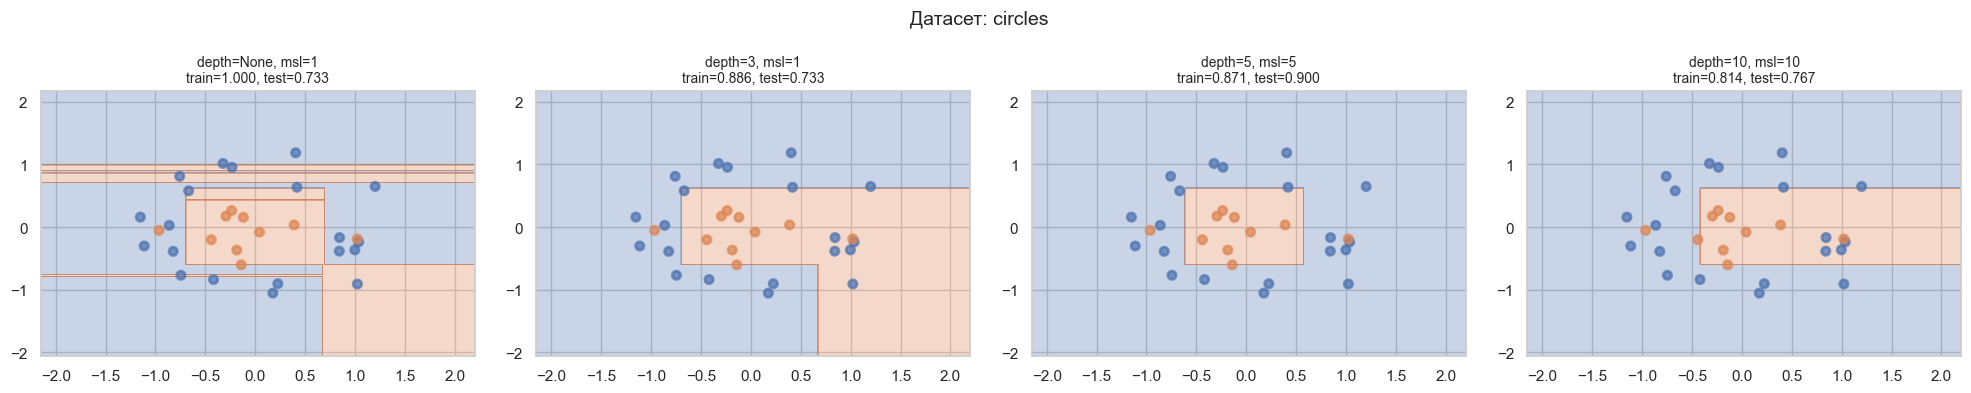

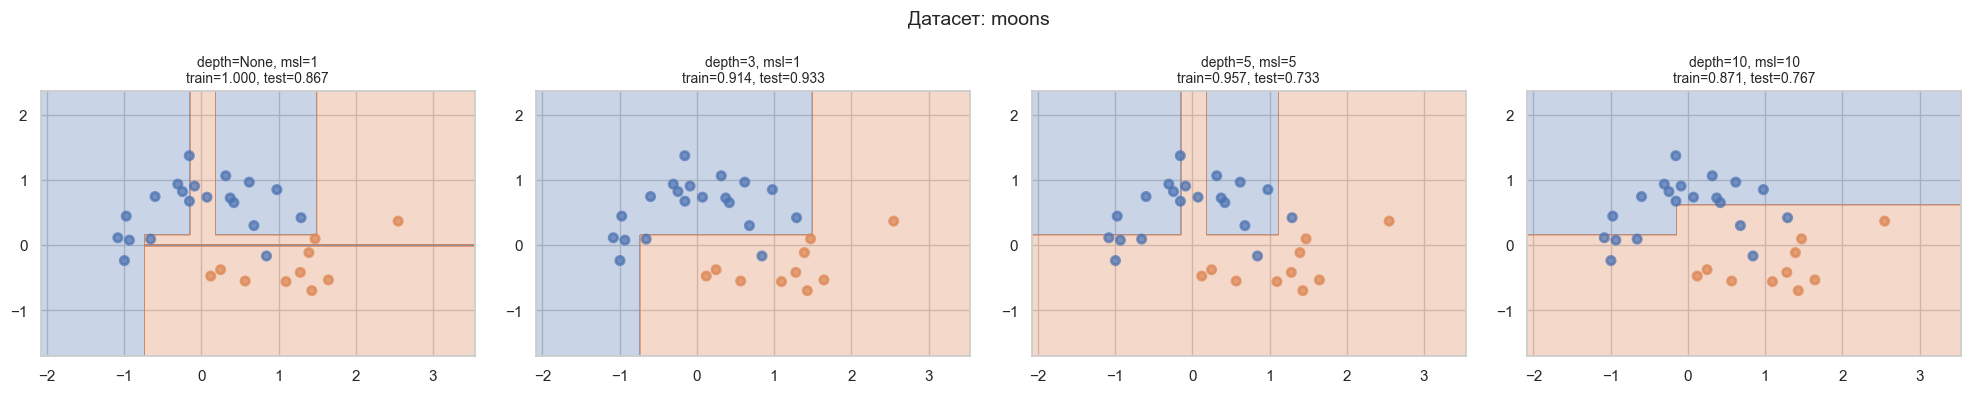

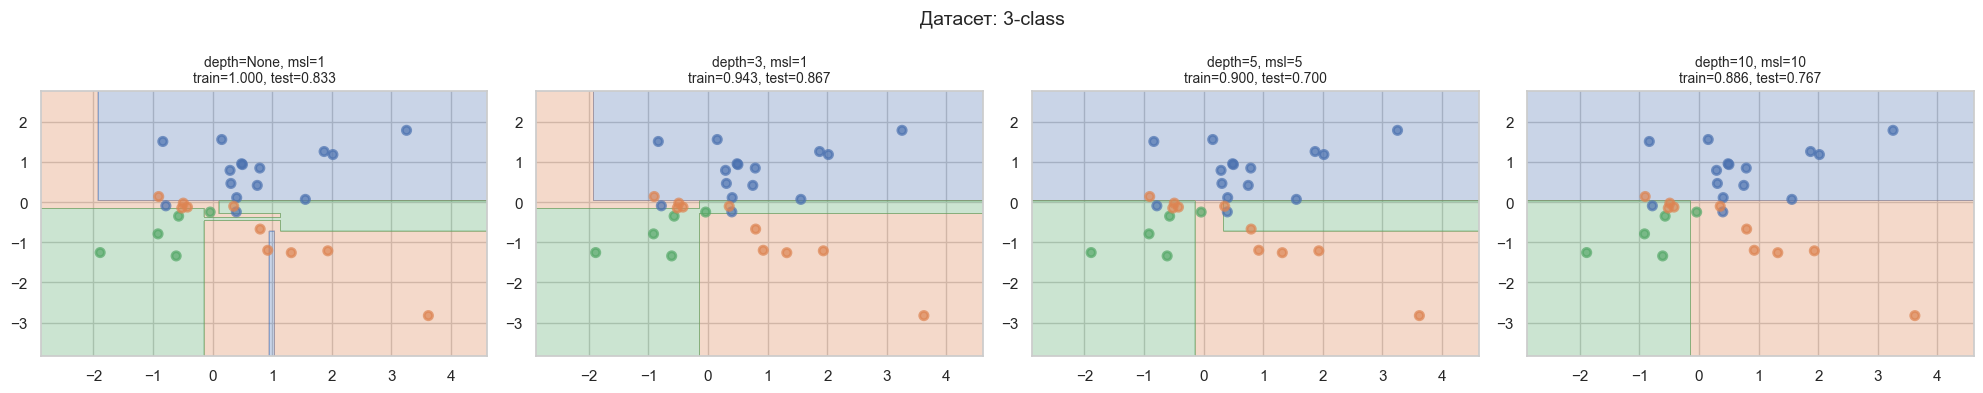

In [26]:
params_grid = [
    {'max_depth': None, 'min_samples_leaf': 1},
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 5},
    {'max_depth': 10, 'min_samples_leaf': 10},
]

for ds_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    fig, axes = plt.subplots(1, len(params_grid), figsize=(20, 4))
    fig.suptitle(f'Датасет: {dataset_names[ds_idx]}', fontsize=14)
    
    for j, params in enumerate(params_grid):
        clf = DecisionTreeClassifier(random_state=42, **params)
        clf.fit(X_train, y_train)
        
        acc_train = accuracy_score(y_train, clf.predict(X_train))
        acc_test = accuracy_score(y_test, clf.predict(X_test))
        
        plt.sca(axes[j])
        plot_surface(clf, X_test, y_test)
        axes[j].set_title(f'depth={params["max_depth"]}, msl={params["min_samples_leaf"]}\n'
                          f'train={acc_train:.3f}, test={acc_test:.3f}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

**Ответ:** При ограничении глубины и увеличении min_samples_leaf разделяющая поверхность становится более гладкой, переобучение уменьшается. Для circles и moons оптимально небольшое дерево (depth=3-5), для 3-class с большим разделением классов даже простое дерево работает хорошо.

---
# 2. Решающие деревья на 5 датасетах

### 2.1 (0.5 балла) Mushrooms

In [27]:
# Распаковка всех zip
for zf in glob.glob('datasets/*.zip'):
    name = os.path.splitext(os.path.basename(zf))[0]
    out_dir = f'datasets/{name}'
    if not os.path.exists(out_dir):
        with zipfile.ZipFile(zf, 'r') as z:
            z.extractall(out_dir)
        print(f'Распакован: {zf} -> {out_dir}')

# Ищем файлы
for d in glob.glob('datasets/*/'):
    files = os.listdir(d)
    print(f'{d}: {files[:5]}')

datasets/HomeCredit/: ['HomeCredit_columns_description.csv', 'application_train.csv']
datasets/tic-tac-toe/: ['tic-tac-toe.names', 'tic-tac-toe.data', 'Index']
datasets/mushroom/: ['README', 'expanded.Z', 'agaricus-lepiota.data', 'agaricus-lepiota.names', 'Index']
datasets/user-knowledge-modeling/: ['Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls']
datasets/cars/: ['car.data', 'car.names', 'car.c45-names']
datasets/nursery/: ['nursery.c45-names', 'nursery.names', 'nursery.data']


In [28]:
# Загрузка mushrooms
mush_path = glob.glob('datasets/mushroom*/*.data') + glob.glob('datasets/mushroom*/**/*.data', recursive=True)
if not mush_path:
    mush_path = glob.glob('datasets/mushroom*/*.csv') + glob.glob('datasets/mushroom*/**/*.csv', recursive=True)
print('Mushroom files:', mush_path)

df_mush = pd.read_csv(mush_path[0], header=None)
print(f'Shape: {df_mush.shape}')

# Первый столбец — класс (e/p)
le_dict = {}
for col in df_mush.columns:
    le = LabelEncoder()
    df_mush[col] = le.fit_transform(df_mush[col].astype(str))
    le_dict[col] = le

y_mush = df_mush[0].values
X_mush = df_mush.drop(columns=[0]).values

clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X_mush, y_mush, cv=10,
                         scoring=make_scorer(accuracy_score))
print(f'Mushrooms accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

Mushroom files: ['datasets/mushroom/agaricus-lepiota.data', 'datasets/mushroom/agaricus-lepiota.data']
Shape: (8124, 23)
Mushrooms accuracy: 0.9604 ± 0.0949


### 2.2 (2 балла) Сравнение на 5 датасетах

In [29]:
def load_dataset(name, class_col, class_map=None):
    """Загружает датасет из zip, применяет LabelEncoder."""
    paths = (glob.glob(f'datasets/{name}*/*.data', recursive=True) +
             glob.glob(f'datasets/{name}*/**/*.data', recursive=True) +
             glob.glob(f'datasets/{name}*/*.csv', recursive=True) +
             glob.glob(f'datasets/{name}*/**/*.csv', recursive=True))
    # Фильтруем .names файлы
    paths = [p for p in paths if not p.endswith('.names')]
    print(f'{name}: {paths}')
    
    df = pd.read_csv(paths[0], header=None)
    
    # Кодируем все столбцы
    for col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    if class_col == 0:
        y = df[0].values
        X = df.drop(columns=[0]).values
        X_df = df.drop(columns=[0])
    else:
        last = df.columns[-1]
        y = df[last].values
        X = df.drop(columns=[last]).values
        X_df = df.drop(columns=[last])
    
    # Бинаризация классов если нужно
    if class_map is not None:
        y_new = np.zeros_like(y)
        for cls_val in class_map:
            y_new[y == cls_val] = class_map[cls_val]
        y = y_new
    
    return X, y, X_df

In [30]:
# Загружаем все датасеты
all_datasets = {}

# Mushrooms (класс в столбце 0)
all_datasets['mushrooms'] = load_dataset('mushroom', class_col=0)

# Tic-tac-toe (класс в последнем столбце)
all_datasets['tic-tac-toe'] = load_dataset('tic-tac-toe', class_col=-1)

# Cars (класс в последнем)
all_datasets['cars'] = load_dataset('car', class_col=-1)

# Nursery (класс в последнем)
all_datasets['nursery'] = load_dataset('nursery', class_col=-1)

# User-knowledge-modeling — отдельная загрузка (xls файл)
with zipfile.ZipFile('datasets/user-knowledge-modeling.zip', 'r') as z:
    z.extractall('datasets/user-knowledge-modeling')
xls_path = glob.glob('datasets/user-knowledge-modeling*/**/*.xls*', recursive=True)[0]
df_uk = pd.read_excel(xls_path, engine='xlrd')
le = LabelEncoder()
y_uk = le.fit_transform(df_uk.iloc[:, -1])
X_uk = df_uk.iloc[:, :-1].values
X_uk_df = df_uk.iloc[:, :-1]
all_datasets['user-knowledge'] = (X_uk, y_uk, X_uk_df)

for name, (X, y, _) in all_datasets.items():
    print(f'{name}: X={X.shape}, classes={np.unique(y)}')

mushroom: ['datasets/mushroom/agaricus-lepiota.data', 'datasets/mushroom/agaricus-lepiota.data']
tic-tac-toe: ['datasets/tic-tac-toe/tic-tac-toe.data', 'datasets/tic-tac-toe/tic-tac-toe.data']
car: ['datasets/cars/car.data', 'datasets/cars/car.data']
nursery: ['datasets/nursery/nursery.data', 'datasets/nursery/nursery.data']
mushrooms: X=(8124, 22), classes=[0 1]
tic-tac-toe: X=(958, 9), classes=[0 1]
cars: X=(1728, 6), classes=[0 1 2 3]
nursery: X=(12960, 8), classes=[0 1 2 3 4]
user-knowledge: X=(12, 2), classes=[0 1 2 3 4 5 6]


In [35]:
results = {}

for name, (X, y, X_df) in all_datasets.items():
    row = {}
    
    # Выбираем cv в зависимости от минимального класса
    min_class_count = min(np.bincount(y))
    cv = int(min(10, min_class_count))
    cv = int(max(2, min(10, min_class_count)))
    # 1. DecisionTree (все признаки как вещественные)
    clf = DecisionTreeClassifier(random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    row['DT (numeric)'] = f'{scores.mean():.4f}'

    # 2. DecisionTree (категориальные — LabelEncoder)
    clf_cat = DecisionTreeClassifier(random_state=42)
    scores_cat = cross_val_score(clf_cat, X, y, cv=cv, scoring='accuracy')
    row['DT (categorical)'] = f'{scores_cat.mean():.4f}'

    # 3. DecisionTree + OHE
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X)
    clf_ohe = DecisionTreeClassifier(random_state=42)
    scores_ohe = cross_val_score(clf_ohe, X_ohe, y, cv=cv, scoring='accuracy')
    row['DT + OHE'] = f'{scores_ohe.mean():.4f}'

    results[name] = row
    print(f'{name}: cv={cv}, {row}')

results_df = pd.DataFrame(results).T
results_df

mushrooms: cv=10, {'DT (numeric)': '0.9604', 'DT (categorical)': '0.9604', 'DT + OHE': '0.9564'}
tic-tac-toe: cv=10, {'DT (numeric)': '0.7717', 'DT (categorical)': '0.7717', 'DT + OHE': '0.8040'}
cars: cv=10, {'DT (numeric)': '0.8635', 'DT (categorical)': '0.8635', 'DT + OHE': '0.8392'}
nursery: cv=2, {'DT (numeric)': '0.5416', 'DT (categorical)': '0.5416', 'DT + OHE': '0.5711'}


ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1027, in fit
    super()._fit(
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 255, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/utils/validation.py", line 2914, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1022, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 878, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Area: Education'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1027, in fit
    super()._fit(
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 255, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/utils/validation.py", line 2914, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1022, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 878, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Number of Instances: 403'


### 2.3 (бонус) Графики зависимости от гиперпараметров для tic-tac-toe

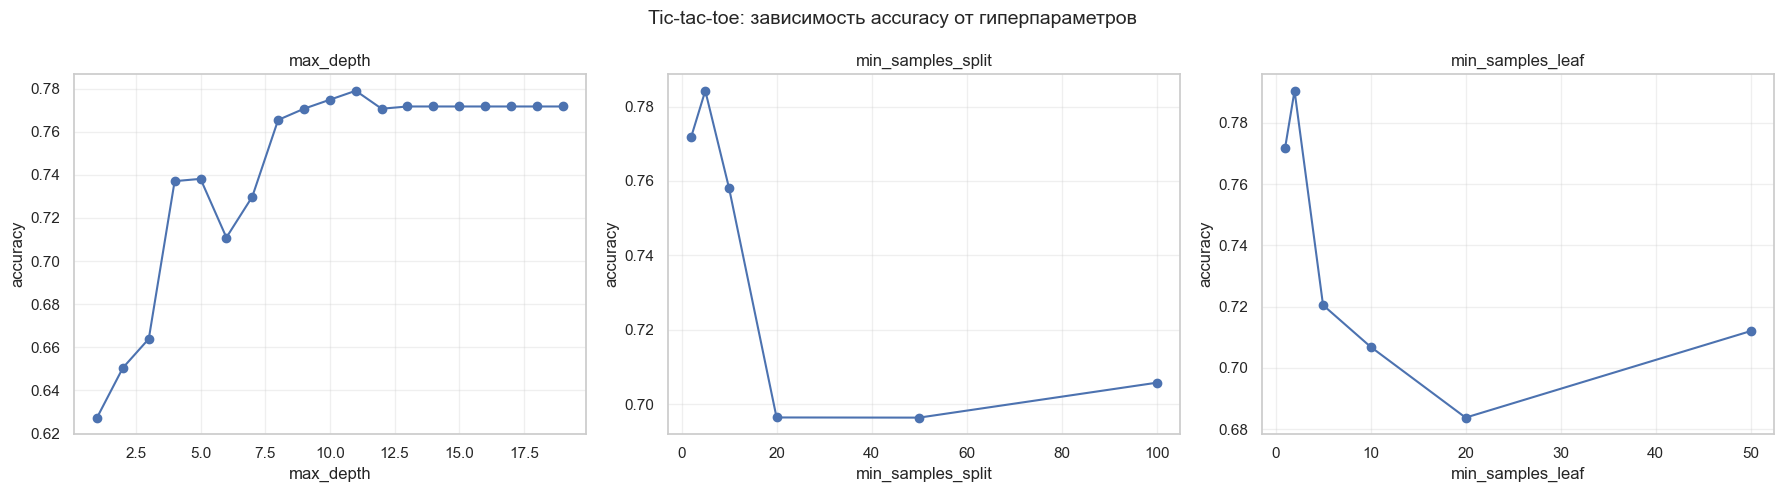

In [36]:
X_ttt, y_ttt, _ = all_datasets['tic-tac-toe']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# max_depth
depths = range(1, 20)
scores_depth = [cross_val_score(DecisionTreeClassifier(max_depth=d, random_state=42),
                                X_ttt, y_ttt, cv=10).mean() for d in depths]
axes[0].plot(depths, scores_depth, '-o')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('accuracy')
axes[0].set_title('max_depth')
axes[0].grid(True, alpha=0.3)

# min_samples_split
splits = [2, 5, 10, 20, 50, 100]
scores_split = [cross_val_score(DecisionTreeClassifier(min_samples_split=s, random_state=42),
                                X_ttt, y_ttt, cv=10).mean() for s in splits]
axes[1].plot(splits, scores_split, '-o')
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('accuracy')
axes[1].set_title('min_samples_split')
axes[1].grid(True, alpha=0.3)

# min_samples_leaf
leaves = [1, 2, 5, 10, 20, 50]
scores_leaf = [cross_val_score(DecisionTreeClassifier(min_samples_leaf=l, random_state=42),
                               X_ttt, y_ttt, cv=10).mean() for l in leaves]
axes[2].plot(leaves, scores_leaf, '-o')
axes[2].set_xlabel('min_samples_leaf')
axes[2].set_ylabel('accuracy')
axes[2].set_title('min_samples_leaf')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Tic-tac-toe: зависимость accuracy от гиперпараметров', fontsize=14)
plt.tight_layout()
plt.show()

### 2.4 (1 балл) Анализ

**Ответ:** Алгоритмы ранжируются по-разному для разных датасетов. OHE помогает для категориальных данных (mushrooms, tic-tac-toe), т.к. LabelEncoder вводит ложный порядок. Для user-knowledge (вещественные признаки) OHE может навредить. Деревья хорошо работают с категориальными данными при правильном кодировании.

---
# 3. Градиентный бустинг

### 3.1 (0.5 балла) Загрузка Home Credit

In [37]:
df_hc = pd.read_csv('datasets/HomeCredit/application_train.csv')
print(f'Shape: {df_hc.shape}')
print(f'TARGET distribution:\n{df_hc["TARGET"].value_counts()}')

Y = df_hc['TARGET'].values
df_hc = df_hc.drop(columns=['TARGET', 'SK_ID_CURR'])

# Определяем типы столбцов
num_cols = df_hc.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_hc.select_dtypes(include=['object']).columns.tolist()
print(f'Числовых: {len(num_cols)}, Категориальных: {len(cat_cols)}')

# Заполняем пропуски
df_hc[num_cols] = df_hc[num_cols].fillna(df_hc[num_cols].median())
df_hc[cat_cols] = df_hc[cat_cols].fillna('missing')

# Разделяем на числовые и категориальные
X_num = df_hc[num_cols].values

X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_num, Y, test_size=0.3, random_state=0
)
print(f'Train: {X_train_num.shape}, Test: {X_test_num.shape}')

Shape: (307511, 122)
TARGET distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Числовых: 104, Категориальных: 16
Train: (215257, 104), Test: (92254, 104)


### 3.2 (1.5 балла) LightGBM и CatBoost без подбора параметров

In [39]:
try:
    import lightgbm as lgb
except ImportError:
    !pip install lightgbm -q
    import lightgbm as lgb

try:
    from catboost import CatBoostClassifier
except ImportError:
    !pip install catboost -q
    from catboost import CatBoostClassifier

OSError: dlopen(/Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D44045CD-B874-3A27-9A61-F131D99AACE4> /Users/v.a.ostanin/PycharmProjects/my-python-devcontainer/.venv1/lib/python3.11/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file)

In [40]:
# LightGBM
t0 = time.time()
lgb_clf = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_clf.fit(X_train_num, y_train)
lgb_time = time.time() - t0

y_pred_lgb = lgb_clf.predict_proba(X_test_num)[:, 1]
lgb_ap = average_precision_score(y_test, y_pred_lgb)
print(f'LightGBM: AP={lgb_ap:.4f}, time={lgb_time:.2f}s')

# CatBoost
t0 = time.time()
cb_clf = CatBoostClassifier(random_state=42, verbose=0)
cb_clf.fit(X_train_num, y_train)
cb_time = time.time() - t0

y_pred_cb = cb_clf.predict_proba(X_test_num)[:, 1]
cb_ap = average_precision_score(y_test, y_pred_cb)
print(f'CatBoost: AP={cb_ap:.4f}, time={cb_time:.2f}s')

print('\nРазница в качестве может быть вызвана разными параметрами по умолчанию:')
print('количество деревьев, глубина, learning_rate, обработка категорий.')

NameError: name 'lgb' is not defined

### 3.3 (2 балла) Подбор параметров с CV=3

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Берём подвыборку для ускорения CV
n_sub = min(20000, len(X_train_num))
idx_sub = np.random.RandomState(42).choice(len(X_train_num), n_sub, replace=False)
X_sub = X_train_num[idx_sub]
y_sub = y_train[idx_sub]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM GridSearch
lgb_params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
}

t0 = time.time()
lgb_gs = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    lgb_params, cv=skf, scoring='average_precision', n_jobs=-1
)
lgb_gs.fit(X_sub, y_sub)
lgb_gs_time = time.time() - t0
print(f'LightGBM best: {lgb_gs.best_params_}, AP={lgb_gs.best_score_:.4f}, time={lgb_gs_time:.1f}s')

In [ ]:
# CatBoost — перебираем вручную (GridSearchCV с CatBoost может быть медленным)
best_cb_ap = 0
best_cb_params = {}

for depth in [3, 5, 7]:
    for n_est in [100, 300]:
        for lr in [0.05, 0.1]:
            scores = []
            for tr_idx, val_idx in skf.split(X_sub, y_sub):
                cb = CatBoostClassifier(
                    depth=depth, iterations=n_est, learning_rate=lr,
                    random_state=42, verbose=0
                )
                cb.fit(X_sub[tr_idx], y_sub[tr_idx])
                pred = cb.predict_proba(X_sub[val_idx])[:, 1]
                scores.append(average_precision_score(y_sub[val_idx], pred))
            mean_ap = np.mean(scores)
            if mean_ap > best_cb_ap:
                best_cb_ap = mean_ap
                best_cb_params = {'depth': depth, 'iterations': n_est, 'learning_rate': lr}

print(f'CatBoost best: {best_cb_params}, AP={best_cb_ap:.4f}')

print(f'\nСоотношение глубины и числа деревьев:')
print(f'LightGBM: depth={lgb_gs.best_params_["max_depth"]}, n_est={lgb_gs.best_params_["n_estimators"]}')
print(f'CatBoost: depth={best_cb_params["depth"]}, n_est={best_cb_params["iterations"]}')

### 3.4 (3.5 балла) Категориальные признаки: OHE и счётчики

In [ ]:
# Полный DataFrame с числовыми и категориальными
df_full = df_hc.copy()

# --- OHE ---
df_ohe = pd.get_dummies(df_full, columns=cat_cols, drop_first=True).astype(np.float32)
X_train_ohe, X_test_ohe, y_tr, y_te = train_test_split(
    df_ohe.values, Y, test_size=0.3, random_state=0
)

t0 = time.time()
lgb_ohe = lgb.LGBMClassifier(verbose=-1, random_state=42, **lgb_gs.best_params_)
lgb_ohe.fit(X_train_ohe, y_tr)
lgb_ohe_time = time.time() - t0
y_pred = lgb_ohe.predict_proba(X_test_ohe)[:, 1]
print(f'LightGBM + OHE: AP={average_precision_score(y_te, y_pred):.4f}, time={lgb_ohe_time:.2f}s')

# --- Счётчики со сглаживанием ---
alpha = 10  # параметр сглаживания
global_mean = Y.mean()

df_count = df_full.copy()
# Сплит для подсчёта счётчиков (считаем только на train!)
train_idx, test_idx = train_test_split(np.arange(len(Y)), test_size=0.3, random_state=0)

for col in cat_cols:
    # Считаем на train
    stats = df_count.iloc[train_idx].groupby(col)['__target__'] if '__target__' in df_count.columns else None
    # Добавляем target временно
    df_temp = df_count[[col]].copy()
    df_temp['target'] = np.nan
    df_temp.loc[train_idx, 'target'] = Y[train_idx]
    
    agg = df_temp.iloc[train_idx].groupby(col)['target'].agg(['mean', 'count'])
    agg['smoothed'] = (agg['mean'] * agg['count'] + global_mean * alpha) / (agg['count'] + alpha)
    mapping = agg['smoothed'].to_dict()
    
    df_count[col] = df_count[col].map(mapping).fillna(global_mean)

X_count_all = df_count[num_cols + cat_cols].values.astype(np.float32)
X_train_cnt = X_count_all[train_idx]
X_test_cnt = X_count_all[test_idx]
y_tr_cnt = Y[train_idx]
y_te_cnt = Y[test_idx]

t0 = time.time()
lgb_cnt = lgb.LGBMClassifier(verbose=-1, random_state=42, **lgb_gs.best_params_)
lgb_cnt.fit(X_train_cnt, y_tr_cnt)
lgb_cnt_time = time.time() - t0
y_pred_cnt = lgb_cnt.predict_proba(X_test_cnt)[:, 1]
print(f'LightGBM + Counters: AP={average_precision_score(y_te_cnt, y_pred_cnt):.4f}, time={lgb_cnt_time:.2f}s')

# --- CatBoost с встроенной обработкой категорий ---
df_catboost = df_full.copy()
for col in cat_cols:
    df_catboost[col] = LabelEncoder().fit_transform(df_catboost[col])

X_cb_all = df_catboost.values
X_train_cb, X_test_cb = X_cb_all[train_idx], X_cb_all[test_idx]
cat_indices = [df_catboost.columns.tolist().index(c) for c in cat_cols]

t0 = time.time()
cb_native = CatBoostClassifier(verbose=0, random_state=42, **best_cb_params,
                                cat_features=cat_indices)
cb_native.fit(X_train_cb, y_tr_cnt)
cb_native_time = time.time() - t0
y_pred_native = cb_native.predict_proba(X_test_cb)[:, 1]
print(f'CatBoost (native cat): AP={average_precision_score(y_te_cnt, y_pred_native):.4f}, time={cb_native_time:.2f}s')

### 3.5 (1 балл) Блендинг

In [ ]:
# Блендинг: среднее предсказаний лучших моделей
# Пересчитываем на общем тестовом сплите
lgb_best = lgb.LGBMClassifier(verbose=-1, random_state=42, **lgb_gs.best_params_)
lgb_best.fit(X_train_num, y_train)
pred_lgb = lgb_best.predict_proba(X_test_num)[:, 1]

cb_best = CatBoostClassifier(verbose=0, random_state=42, **best_cb_params)
cb_best.fit(X_train_num, y_train)
pred_cb = cb_best.predict_proba(X_test_num)[:, 1]

# Блендинг
pred_blend = 0.5 * pred_lgb + 0.5 * pred_cb

ap_lgb = average_precision_score(y_test, pred_lgb)
ap_cb = average_precision_score(y_test, pred_cb)
ap_blend = average_precision_score(y_test, pred_blend)

print(f'LightGBM:  AP={ap_lgb:.4f}')
print(f'CatBoost:  AP={ap_cb:.4f}')
print(f'Blend:     AP={ap_blend:.4f}')

# Попробуем разные веса
best_w, best_ap = 0, 0
for w in np.arange(0, 1.05, 0.05):
    ap = average_precision_score(y_test, w * pred_lgb + (1-w) * pred_cb)
    if ap > best_ap:
        best_ap = ap
        best_w = w
print(f'Best blend: w_lgb={best_w:.2f}, AP={best_ap:.4f}')

### 3.6 (1.5 балла) Feature importance

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# LightGBM importance
lgb_imp = pd.Series(lgb_best.feature_importances_, index=num_cols).sort_values()
lgb_imp.tail(20).plot(kind='barh', ax=ax1)
ax1.set_title('LightGBM Feature Importance (top 20)')

# CatBoost importance
cb_imp = pd.Series(cb_best.feature_importances_, index=num_cols).sort_values()
cb_imp.tail(20).plot(kind='barh', ax=ax2)
ax2.set_title('CatBoost Feature Importance (top 20)')

plt.tight_layout()
plt.show()

In [ ]:
# Удаляем неважные признаки (нижние 50% по важности)
for model_name, imp, model_cls, params in [
    ('LightGBM', lgb_imp, lgb.LGBMClassifier, {**lgb_gs.best_params_, 'verbose': -1, 'random_state': 42}),
    ('CatBoost', cb_imp, CatBoostClassifier, {**best_cb_params, 'verbose': 0, 'random_state': 42}),
]:
    threshold = imp.quantile(0.5)
    important_feats = imp[imp > threshold].index.tolist()
    feat_idx = [num_cols.index(f) for f in important_feats]
    
    X_tr_sel = X_train_num[:, feat_idx]
    X_te_sel = X_test_num[:, feat_idx]
    
    clf = model_cls(**params)
    clf.fit(X_tr_sel, y_train)
    pred = clf.predict_proba(X_te_sel)[:, 1]
    ap_sel = average_precision_score(y_test, pred)
    
    print(f'{model_name}: {len(important_feats)}/{len(num_cols)} признаков, AP={ap_sel:.4f} '
          f'(было {ap_lgb if "Light" in model_name else ap_cb:.4f})')

**Вывод:** При удалении ~50% наименее важных признаков качество почти не падает, что подтверждает корректность ранжирования признаков моделями. Это позволяет значительно упростить модель без потери качества.